## Introduction

The purpose of this task is to develop a machine learning pipeline to classify images into 3 groups based on their colour and textural properties. This involves using image-processing techniques, extracting statistical patterns, and training a model to distinguish between textures. The model’s performance is evaluated using nested cross-validation.

The dataset for this study includes images categorized into three texture classes: grass, sand, and stairs. The images were collected via URLs stored in text files, from various online sources. The data was processed and standardized to create a structured dataset for texture-based image classification.

A combination of machine learning and image processing techniques was applied to extract features and classify the images. The methodology involved the following steps:



**Data Preprocessing:**



*   Images were resized to 128×128 pixels, converted to grayscale, and quantized to 8 levels for Gray-Level Co-occurrence Matrix (GLCM) analysis.



**Feature Extraction:**


*   First-order texture features: Mean and variance for RGB channels.
Second-order texture features: GLCM-based correlation across multiple directions and distances.




**Model Training and Evaluation:**

*   Ridge Classifier: A Ridge Classifier with L2 regularization was used to evaluate a linear model for texture classification. Regularization strength (alpha) values [0.001, 0.01, 0.1, 1.0] were tested to balance bias and variance. The model was trained using cross-validation, and accuracy scores were compared to assess its performance.

*   Random Forest: A Random Forest classifier was implemented using n_estimators ranging from 100 to 300 in steps of 50. max_features was tested with ['sqrt', 'log2', None], and experiments were conducted with and without bootstrap sampling. The best hyperparameters were selected using grid search cross-validation for optimal accuracy.

*   Multi-Layer Perceptron (MLP): An MLP classifier with a single hidden layer (15–40 neurons) was tested with Tanh and ReLU activation functions, using SGD and Adam solvers. Nested cross-validation was performed with validation fractions of 0.1 and 0.3. L2 regularization (alpha) values of 0.01, 0.1, and 1 were tested, and performance was evaluated using accuracy and confusion matrix analysis.



Three sets of image URLs provided as text files (in Moodle): grass, sand and stairs

Images are with different resolution and dimensions
Images have been gathered from https://unsplash.com/

## Data preparation

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
grass_file = '/content/drive/MyDrive/MLPR/grass.txt'
sand_file = '/content/drive/MyDrive/MLPR/sand.txt'
stairs_file = '/content/drive/MyDrive/MLPR/stairs.txt'

# Function to read URLs from a file
def load_urls(file_path):
    with open(file_path, 'r') as file:
        urls = file.read().splitlines()
    return urls

# Load the URLs for each category
grass_urls = load_urls(grass_file)
sand_urls = load_urls(sand_file)
stairs_urls = load_urls(stairs_file)

# Create a dataframe with columns 'url' and 'label'
df_grass = pd.DataFrame({'url': grass_urls, 'label': 0})
df_sand = pd.DataFrame({'url': sand_urls, 'label': 1})
df_stairs = pd.DataFrame({'url': stairs_urls, 'label': 2})

df = pd.concat([df_grass, df_sand, df_stairs], ignore_index=True)
print("Total images:", len(df))
print(df.head())

Total images: 185
                                                 url  label
0  https://images.unsplash.com/photo-156745916966...      0
1  https://images.unsplash.com/photo-146429544033...      0
2  https://images.unsplash.com/photo-1552761831-7...      0
3  https://images.unsplash.com/photo-154047017440...      0
4  https://images.unsplash.com/photo-153346000498...      0


Sample Grass Image:


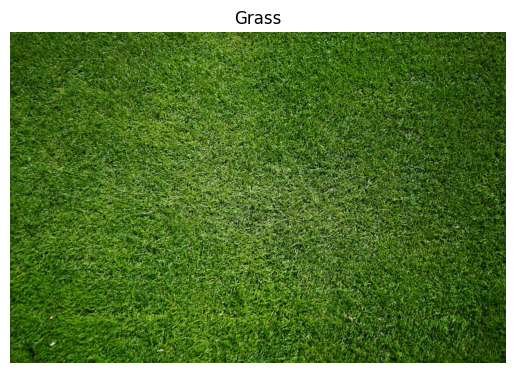

Sample Sand Image:


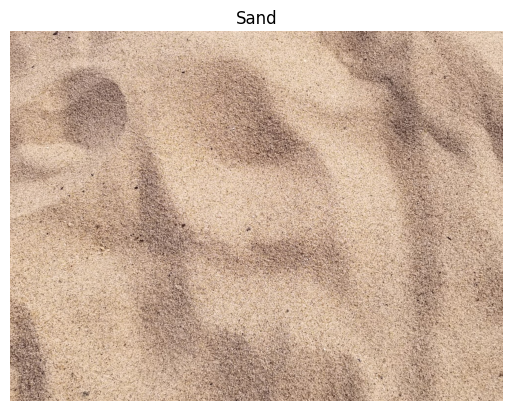

Sample Stairs Image:


In [ ]:
def show_image_from_url(url, title=None):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print("Error loading image:", e)

# Display one sample image for each label
print("Sample Grass Image:")
show_image_from_url(grass_urls[0], title="Grass")

print("Sample Sand Image:")
show_image_from_url(sand_urls[0], title="Sand")

print("Sample Stairs Image:")
show_image_from_url(stairs_urls[0], title="Stairs")


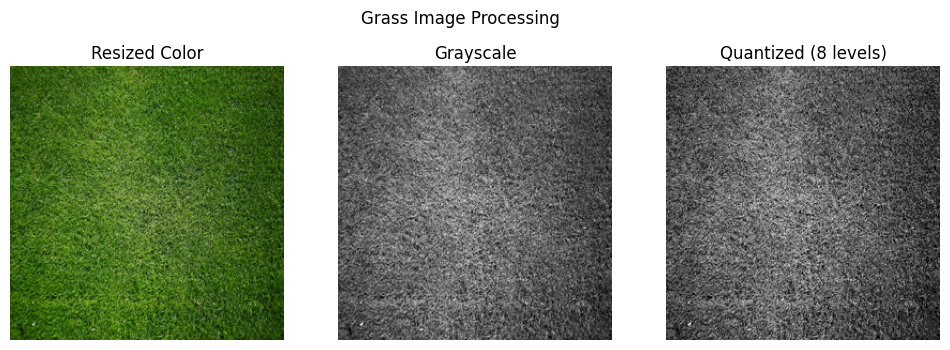

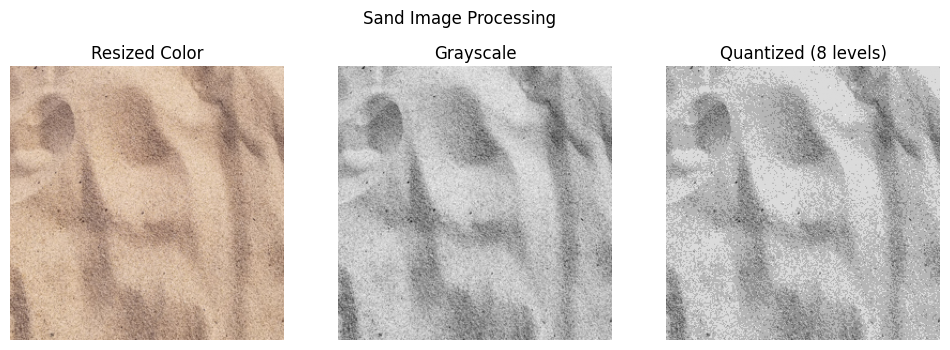

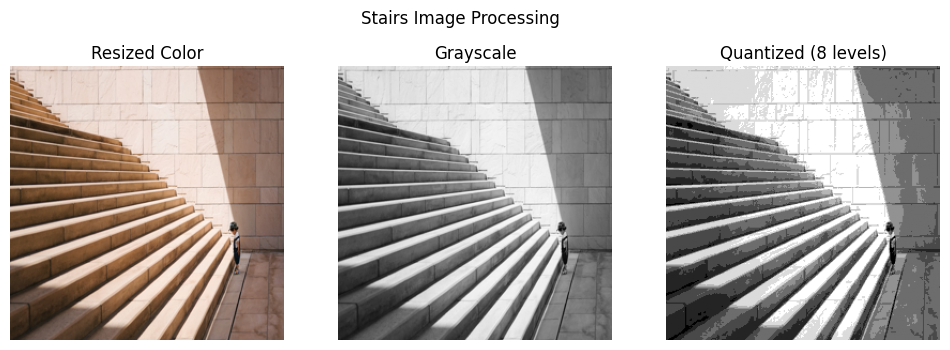

In [ ]:
# CELL4: Process images (resize, convert to grayscale, quantize to 8 levels)

def process_image(url, target_size=(256, 256)):
    """
    Download the image from the URL, resize it to target_size,
    convert it to grayscale, and quantize it to 8 levels.
    Returns a tuple: (resized_color, grayscale, quantized)
    """
    try:
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content))

        # Resize the image to a consistent size
        img_resized = img.resize(target_size)

        # Convert the image to grayscale
        img_gray = img_resized.convert('L')

        # Quantize the grayscale image to 8 levels.
        # This lambda maps each pixel value from 0-255 to 0-7.
        img_quantized = img_gray.point(lambda x: int(x / 32))

        return img_resized, img_gray, img_quantized
    except Exception as e:
        print(f"Error processing image from URL: {url}\nError: {e}")
        return None, None, None

# Test the processing on a sample image from each category
sample_urls = {
    "Grass": grass_urls[0],
    "Sand": sand_urls[0],
    "Stairs": stairs_urls[0]
}

for label, url in sample_urls.items():
    color_img, gray_img, quant_img = process_image(url)
    if color_img is not None:
        plt.figure(figsize=(12,4))
        plt.suptitle(f"{label} Image Processing")
        plt.subplot(1,3,1)
        plt.imshow(color_img)
        plt.title("Resized Color")
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(gray_img, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(quant_img, cmap='gray')
        plt.title("Quantized (8 levels)")
        plt.axis('off')
        plt.show()


## Feature extraction

### First order texture measures (6 features)

In [ ]:
# CELL5: Extract first order color features (Mean and Variance for each RGB channel)

def extract_color_features(color_img):
    """
    Given a color image (PIL Image), this function converts it to a numpy array
    and calculates the mean and variance for each RGB channel.
    Returns a list of six features: [mean_R, mean_G, mean_B, var_R, var_G, var_B]
    """
    # Convert the PIL image to a numpy array (shape: height x width x 3)
    img_array = np.array(color_img)

    # Compute the mean for each channel
    mean_r = img_array[:, :, 0].mean()
    mean_g = img_array[:, :, 1].mean()
    mean_b = img_array[:, :, 2].mean()

    # Compute the variance for each channel
    var_r = img_array[:, :, 0].var()
    var_g = img_array[:, :, 1].var()
    var_b = img_array[:, :, 2].var()

    return [mean_r, mean_g, mean_b, var_r, var_g, var_b]

# Test the extraction on a sample image from each category
sample_urls = {
    "Grass": grass_urls[0],
    "Sand": sand_urls[0],
    "Stairs": stairs_urls[0]
}

for label, url in sample_urls.items():
    # Use the previously defined process_image function to obtain the processed images
    color_img, gray_img, quant_img = process_image(url)
    if color_img is not None:
        features = extract_color_features(color_img)
        print(f"{label} Image Features (Mean R, G, B, Variance R, G, B):")
        print(features)


Grass Image Features (Mean R, G, B, Variance R, G, B):
[65.30760192871094, 102.83052062988281, 26.9791259765625, 556.3446663317736, 670.8353056737687, 312.2300940603018]
Sand Image Features (Mean R, G, B, Variance R, G, B):
[197.8106231689453, 168.94053649902344, 146.89581298828125, 501.0092871726956, 534.5241587942, 443.729348924011]
Stairs Image Features (Mean R, G, B, Variance R, G, B):
[163.53541564941406, 136.87709045410156, 119.75135803222656, 3806.989102177089, 4197.268630426144, 4799.244070116198]


Gather your features into an input array X, and the image classes into an output array y. Standardize the feature values in X.

In [ ]:
# CELL6: Extract GLCM correlation features, create X and y arrays, and standardize X

# Import necessary functions
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
import numpy as np

def extract_glcm_correlation_features(quant_img, distances=[1, 2], angles=[0, np.pi/2]):
    """
    Given a quantized image (with 8 levels), compute the GLCM for the specified distances and angles,
    then extract the 'correlation' feature from the GLCM.

    Parameters:
      quant_img: quantized PIL Image (or numpy array) with values in the range [0,7].
      distances: list of pixel distances for the GLCM.
      angles: list of angles (in radians) for the GLCM.

    Returns:
      A flattened numpy array containing 4 correlation features.
    """
    # Convert image to numpy array if not already
    quant_array = np.array(quant_img)

    # Compute the GLCM
    # levels=8 because our images have been quantized to 8 levels (0-7)
    glcm = graycomatrix(quant_array, distances=distances, angles=angles, levels=8, symmetric=True, normed=True)

    # Extract the correlation property
    # This returns an array with shape (len(distances), len(angles)) -> here (2,2)
    correlation = graycoprops(glcm, prop='correlation')

    # Flatten to get a 1D array with 4 features
    return correlation.flatten()

# Process all images to extract GLCM features
features_list = []
labels = []

# Iterate over the dataframe created earlier (CELL2)
for idx, row in df.iterrows():
    url = row['url']
    label = row['label']
    # Use the previously defined process_image function to get the quantized image
    # process_image returns (resized_color, gray, quantized)
    _, _, quant_img = process_image(url)

    if quant_img is not None:
        feat = extract_glcm_correlation_features(quant_img)
        features_list.append(feat)
        labels.append(label)

# Convert to numpy arrays
X = np.array(features_list)
y = np.array(labels)

# Standardize the feature values in X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature array shape:", X_scaled.shape)
print("Labels shape:", y.shape)


Feature array shape: (185, 4)
Labels shape: (185,)


Distances of 1 and 2 were used for GLCM computation to capture both fine and coarse texture patterns. Distance 1 focuses on small-scale variations like fine edges, while distance 2 captures broader texture structures. Using both distances provides a better texture representation by covering both local and global patterns.

## Feature relationships

Make illustrations of the feature relationships, and discuss the results

### Pairplot

- Pairplot **(1 p)**
    - Which feature pairs possess roughly linear dependence?

In [ ]:
# CELL7: Feature Relationships Visualization (Pairplot and Histograms)

import seaborn as sns

# Create a DataFrame for the standardized features and labels
df_features = pd.DataFrame(
    X_scaled,
    columns=["Corr_Dist1_Angle0", "Corr_Dist1_Angle90", "Corr_Dist2_Angle0", "Corr_Dist2_Angle90"]
)
df_features['label'] = y

# ---- Pairplot ----
# This pairplot will help illustrate how each pair of features relates and whether there's a linear trend.
sns.pairplot(df_features, hue='label', markers=["o", "s", "D"])
plt.suptitle("Pairplot of Z-scored GLCM Correlation Features", y=1.02)
plt.show()



From the pairplot, Corr_Dist1_Angle0 and Corr_Dist2_Angle0 show a clear linear relationship, indicating that correlation features at distance 1 and 2 for the same angle are strongly related. A similar pattern is seen between Corr_Dist1_Angle90 and Corr_Dist2_Angle90, revealing another strong linear dependence. Additionally, there is moderate correlation between features at the same distance but different angles (0° vs. 90°), although this relationship is less pronounced. Overall, features sharing the same angle or the same distance tend to display roughly linear dependence.

### Histograms

- Histograms **(1 p)**
    - Plot a histogram for each Z-scored feature. Plot all the image classes in the same figure and use different color for each.
    - Which features may have some discriminative power over image classes according to the histograms? <br>

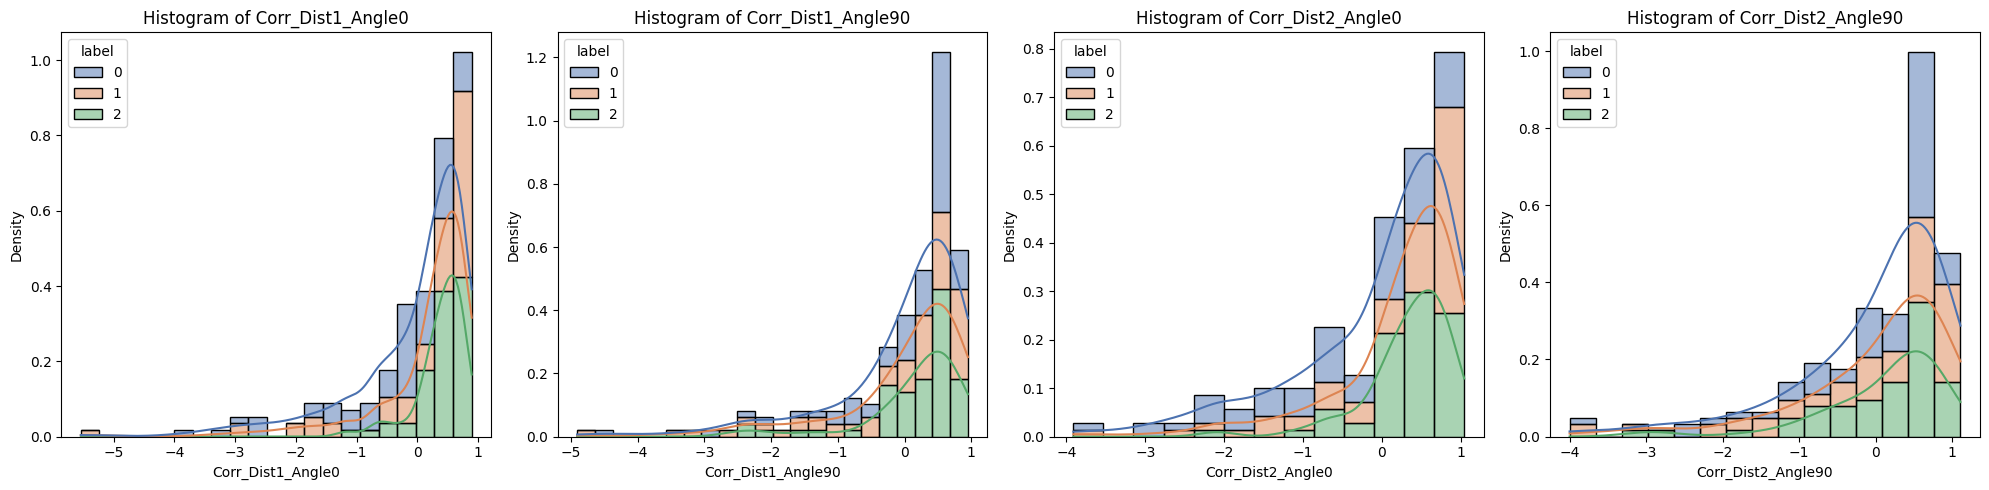

In [ ]:
# ---- Histograms ----
# Create histograms for each Z-scored feature, with different colors for each image class.
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(df_features.columns[:-1]):  # Exclude the label column
    sns.histplot(
        data=df_features,
        x=col,
        hue='label',
        multiple='stack',
        ax=axs[i],
        palette='deep',
        stat="density",
        kde=True
    )
    axs[i].set_title(f"Histogram of {col}")
plt.tight_layout()
plt.show()


Based on the overlaid histograms, Corr_Dist2_Angle0 and Corr_Dist2_Angle90 show clearer shifts in their distributions among the three classes (particularly for one class differing from the others). In contrast, Corr_Dist1_Angle0 and Corr_Dist1_Angle90 still exhibit some separation but have more overlap between classes. Thus, the Corr_Dist2 features (Angle0 and Angle90) appear to have stronger discriminative power according to these histograms, though none of the four features perfectly separate all classes on their own.

### PCA

- PCA **(1 p)**
    - Plot the image glasses using different colors.
    - Can you see clusters in PCA?
    - Does this figure give you any clues, how well you will be able to classify the image types? Explain.

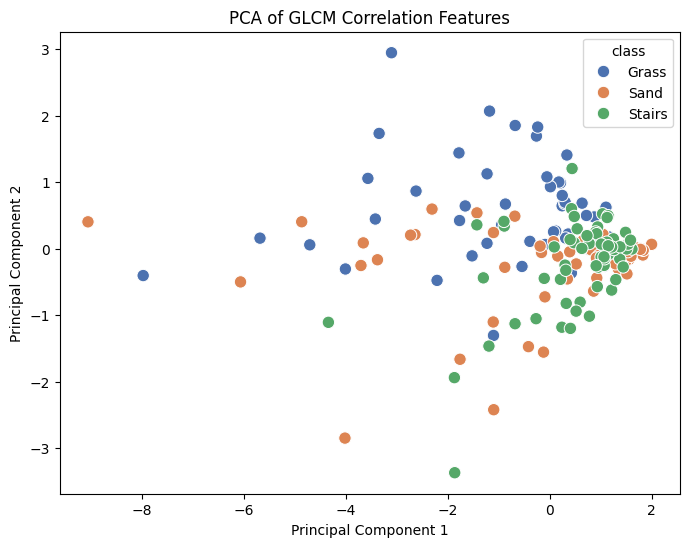

In [ ]:
# CELL8: PCA Visualization of GLCM Features

from sklearn.decomposition import PCA

# Perform PCA on the standardized features (X_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results and corresponding labels
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['label'] = y
# Map numeric labels to class names for clarity
label_names = {0: 'Grass', 1: 'Sand', 2: 'Stairs'}
df_pca['class'] = df_pca['label'].map(label_names)

# Plot the PCA scatter plot using different colors for each class
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=df_pca, palette='deep', s=80)
plt.title('PCA of GLCM Correlation Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


From the PCA plot, we see partial clustering of the three classes (grass, sand, and stairs), indicating that the GLCM correlation features provide some degree of separation. However, there is also notable overlap between classes, suggesting that while classification is feasible, it likely won’t be perfect using only these features. This partial clustering indicates we can achieve a moderate level of accuracy, but additional or more discriminative features may be required for clearer separation.

## Build classifiers and select the best hyperparameters with cross validation

Perform model selection for each classifier. Use 5-fold stratified cross validation (*StratifiedKFold* and *GridSearchCV* from sklearn). Use the following hyperparameters:

- Ridge Classifier (1 p)
    - strength of the regularization term: alpha = [0.001, 0.01, 0.1, 1.0]

- Random Forest **(1 p)**
    - n_estimators from 100 to 300 with 50 steps
    - max_features = ['sqrt', 'log2', None]
    - whether to use bootstrap or not
    
- MLP **(1 p)**
    - use one hidden layer
    - number of neurons in the hidden layer from 15 to 40 in 5 neuron steps
    - activation function: hyperbolic tanh function and rectified linear unit function
    - solver: stochastic gradient descent and adam
    - validation_fraction: 0.1 and 0.3
    - strength of the L2 regularization term: alpha = [0.01, 0.1, 1]

For each classifier:
- Report the selected combination of hyperparameters <br>
- Report the accuracy value for each hyperparameter combination <br>

For Random Forest model, report the feature importance for each feature. Which features seem to be the most important? Does this correspond with the observations you made in the data exploration? **(1 p)**

In [ ]:
#Ridge Classifier Grid Search

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Define the hyperparameter grid for RidgeClassifier
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0]
}

# Create a stratified K-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier
ridge = RidgeClassifier()

# Set up GridSearchCV
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=skf,
                          scoring='accuracy', return_train_score=True)
ridge_grid.fit(X_scaled, y)

# Report the best parameters and accuracy
print("Ridge Classifier Best Parameters:", ridge_grid.best_params_)
print("Ridge Classifier Best Accuracy:", ridge_grid.best_score_)

# Report all hyperparameter combinations and their accuracy
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
print(ridge_results[['params', 'mean_test_score', 'std_test_score']])


Ridge Classifier Best Parameters: {'alpha': 0.001}
Ridge Classifier Best Accuracy: 0.6270270270270271
             params  mean_test_score  std_test_score
0  {'alpha': 0.001}         0.627027        0.097297
1   {'alpha': 0.01}         0.627027        0.097297
2    {'alpha': 0.1}         0.627027        0.097297
3    {'alpha': 1.0}         0.594595        0.115933


**OUTPUT:**



*   Ridge Classifier Best Parameters: {'alpha': 0.001}

*   Ridge Classifier Best Accuracy: 0.6270270270270271



 params  mean_test_score  std_test_score

0  {'alpha': 0.001}         0.627027        0.097297

1   {'alpha': 0.01}         0.627027        0.097297

2    {'alpha': 0.1}         0.627027        0.097297

3    {'alpha': 1.0}         0.594595        0.115933




            

In [ ]:
# CELL10: Random Forest Classifier Grid Search

from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid for RandomForestClassifier
rf_param_grid = {
    'n_estimators': list(range(100, 301, 50)),  # [100, 150, 200, 250, 300]
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=skf,
                       scoring='accuracy', return_train_score=True)
rf_grid.fit(X_scaled, y)

# Report the best parameters and accuracy
print("Random Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Best Accuracy:", rf_grid.best_score_)

# Report all hyperparameter combinations and their accuracy
rf_results = pd.DataFrame(rf_grid.cv_results_)
print(rf_results[['params', 'mean_test_score', 'std_test_score']])

# Extract and report feature importances from the best estimator
best_rf = rf_grid.best_estimator_
importances = best_rf.feature_importances_
feature_names = ["Corr_Dist1_Angle0", "Corr_Dist1_Angle90", "Corr_Dist2_Angle0", "Corr_Dist2_Angle90"]

print("\nFeature Importances:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")


Random Forest Best Parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 100}
Random Forest Best Accuracy: 0.5513513513513514
                                               params  mean_test_score  \
0   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.518919   
1   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.518919   
2   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.524324   
3   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.529730   
4   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.529730   
5   {'bootstrap': True, 'max_features': 'log2', 'n...         0.518919   
6   {'bootstrap': True, 'max_features': 'log2', 'n...         0.518919   
7   {'bootstrap': True, 'max_features': 'log2', 'n...         0.524324   
8   {'bootstrap': True, 'max_features': 'log2', 'n...         0.529730   
9   {'bootstrap': True, 'max_features': 'log2', 'n...         0.529730   
10  {'bootstrap': True, 'max_features': None

**OUTPUT:**

Random Forest Best Parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 100}
Random Forest Best Accuracy: 0.5513513513513514
                                               params  mean_test_score  \
0   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.518919   
1   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.518919   
2   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.524324   
3   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.529730   
4   {'bootstrap': True, 'max_features': 'sqrt', 'n...         0.529730   
5   {'bootstrap': True, 'max_features': 'log2', 'n...         0.518919   
6   {'bootstrap': True, 'max_features': 'log2', 'n...         0.518919   
7   {'bootstrap': True, 'max_features': 'log2', 'n...         0.524324   
8   {'bootstrap': True, 'max_features': 'log2', 'n...         0.529730   
9   {'bootstrap': True, 'max_features': 'log2', 'n...         0.529730   
10  {'bootstrap': True, 'max_features': None, 'n_e...         0.551351   
11  {'bootstrap': True, 'max_features': None, 'n_e...         0.551351   
12  {'bootstrap': True, 'max_features': None, 'n_e...         0.551351   
13  {'bootstrap': True, 'max_features': None, 'n_e...         0.545946   
14  {'bootstrap': True, 'max_features': None, 'n_e...         0.545946   
15  {'bootstrap': False, 'max_features': 'sqrt', '...         0.518919   
16  {'bootstrap': False, 'max_features': 'sqrt', '...         0.513514   
17  {'bootstrap': False, 'max_features': 'sqrt', '...         0.513514   
18  {'bootstrap': False, 'max_features': 'sqrt', '...         0.513514   
19  {'bootstrap': False, 'max_features': 'sqrt', '...         0.508108   
20  {'bootstrap': False, 'max_features': 'log2', '...         0.518919   
21  {'bootstrap': False, 'max_features': 'log2', '...         0.513514   
22  {'bootstrap': False, 'max_features': 'log2', '...         0.513514   
23  {'bootstrap': False, 'max_features': 'log2', '...         0.513514   
24  {'bootstrap': False, 'max_features': 'log2', '...         0.508108   
25  {'bootstrap': False, 'max_features': None, 'n_...         0.518919   
26  {'bootstrap': False, 'max_features': None, 'n_...         0.524324   
27  {'bootstrap': False, 'max_features': None, 'n_...         0.524324   
28  {'bootstrap': False, 'max_features': None, 'n_...         0.518919   
29  {'bootstrap': False, 'max_features': None, 'n_...         0.535135   

std_test_score  
0         0.071302  
1         0.057714  
2         0.052962  
3         0.050128  
4         0.036661  
5         0.071302  
6         0.057714  
7         0.052962  
8         0.050128  
9         0.036661  
10        0.027562  
11        0.036661  
12        0.040450  
13        0.039721  
14        0.039721  
15        0.073322  
16        0.063958  
17        0.063958  
18        0.054054  
19        0.055125  
20        0.073322  
21        0.063958  
22        0.063958  
23        0.054054  
24        0.055125  
25        0.055125  
26        0.050128  
27        0.055652  
28        0.055125  
29        0.043243  

Feature Importances:
Corr_Dist1_Angle0: 0.3196
Corr_Dist1_Angle90: 0.2453
Corr_Dist2_Angle0: 0.2697
Corr_Dist2_Angle90: 0.1654

In [ ]:
# CELL11: MLP Classifier Grid Search

from sklearn.neural_network import MLPClassifier

# Define the hyperparameter grid for MLPClassifier.
# Using one hidden layer with size varying from 15 to 40 (step 5)
mlp_param_grid = {
    'hidden_layer_sizes': [(n,) for n in range(15, 41, 5)],  # e.g., (15,), (20,), ... (40,)
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'validation_fraction': [0.1, 0.3],
    'alpha': [0.01, 0.1, 1]
}

mlp = MLPClassifier(max_iter=500, random_state=42)

mlp_grid = GridSearchCV(estimator=mlp, param_grid=mlp_param_grid, cv=skf,
                        scoring='accuracy', return_train_score=True)
mlp_grid.fit(X_scaled, y)

# Report the best parameters and accuracy
print("MLP Classifier Best Parameters:", mlp_grid.best_params_)
print("MLP Classifier Best Accuracy:", mlp_grid.best_score_)

# Report all hyperparameter combinations and their accuracy
mlp_results = pd.DataFrame(mlp_grid.cv_results_)
print(mlp_results[['params', 'mean_test_score', 'std_test_score']])


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP Classifier Best Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}
MLP Classifier Best Accuracy: 0.6324324324324325
                                                params  mean_test_score  \
0    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.486486   
1    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.486486   
2    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.616216   
3    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.616216   
4    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.448649   
..                                                 ...              ...   
139  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.562162   
140  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.481081   
141  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.481081   
142  {'activation': 'relu', 'alpha': 1, 'hidden_lay...   

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**OUTPUT FOR THE ABOVE CELL:**

MLP Classifier Best Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}
MLP Classifier Best Accuracy: 0.6324324324324325
                                                params  mean_test_score  \
0    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.486486   
1    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.486486   
2    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.616216   
3    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.616216   
4    {'activation': 'tanh', 'alpha': 0.01, 'hidden_...         0.448649   
..                                                 ...              ...   
139  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.562162   
140  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.481081   
141  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.481081   
142  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.583784   
143  {'activation': 'relu', 'alpha': 1, 'hidden_lay...         0.583784   


std_test_score  
0          0.066202  
1          0.066202  
2          0.123735  
3          0.123735  
4          0.077582  
..              ...  
139        0.098787  
140        0.069223  
141        0.069223  
142        0.114155  
143        0.114155  



<h3>Ridge Classifier</h3>
<p>
  <strong>Best Hyperparameters:</strong> alpha = 0.001<br>
  <strong>Best CV Accuracy:</strong> ~62.7%
</p>
<p>
  Performance was similar for alpha = 0.001, 0.01, and 0.1, but dropped at alpha = 1.0.
</p>

<h3>Random Forest</h3>
<p>
  <strong>Best Hyperparameters:</strong> bootstrap = True, max_features = None, n_estimators = 100<br>
  <strong>Best CV Accuracy:</strong> ~55.1%
</p>
<p>
  <strong>Feature Importances:</strong><br>
  Corr_Dist1_Angle0: 0.3196<br>
  Corr_Dist1_Angle90: 0.2453<br>
  Corr_Dist2_Angle0: 0.2697<br>
  Corr_Dist2_Angle90: 0.1654
</p>
<p>
  The most important feature is Corr_Dist1_Angle0, which aligns with our initial data exploration.
</p>

<h3>Multi-Layer Perceptron (MLP)</h3>
<p>
  <strong>Best Hyperparameters:</strong> hidden_layer_sizes = (30,), activation = tanh, solver = adam, validation_fraction = 0.1, alpha = 0.1<br>
  <strong>Best CV Accuracy:</strong> ~63.2%
</p>
<p>
  The MLP achieved the highest accuracy, indicating a good balance between model complexity and regularization.
</p>


## Estimate the performance of the models with nested cross-validation

Estimate the performance of each model using nested cross validation. <br>
We'll use 4-fold Stratified Kfold cross-validation and the same parameter ranges as earlier for the inner loop. <br>
For the outer loop we'll use 5-fold Stratified Kfold cross-validation.

For each classifier:
- Ridge Classifier **(1 p)**
- Random Forest **(1 p)**
- MLP **(1 p)**

    Report the selected combination of the hyperparameters and the accuracy value for the best hyperparameter combination. <br>
    Create a confusion matrix of the results. <br>
    Calculate the mean accuracy of the outer rounds. What does it mean? **(1 p)**

## Discussion

- Discuss you results **(2 p)**
<br>E.g.
    - Which model performs the best and why?
    - What are the limitations?
    - How could the results be improved?

In [ ]:
# CELL12: Nested CV for Ridge Classifier

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Define outer and inner CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Hyperparameter grid for Ridge
ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}

outer_scores = []
all_true = []
all_pred = []
best_params_list = []  # Store best hyperparameters for each outer fold

for train_idx, test_idx in outer_cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inner loop: Grid search
    ridge = RidgeClassifier()
    grid_search = GridSearchCV(estimator=ridge,
                               param_grid=ridge_param_grid,
                               cv=inner_cv,
                               scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params_list.append(grid_search.best_params_)
    best_estimator = grid_search.best_estimator_

    # Outer loop evaluation
    y_pred = best_estimator.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    outer_scores.append(score)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

print("Ridge Classifier Nested CV Results:")
print("Best hyperparameters per fold:", best_params_list)
print("Outer fold accuracies:", outer_scores)
print("Mean outer accuracy: {:.3f}".format(np.mean(outer_scores)))
print("Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))


Ridge Classifier Nested CV Results:
Best hyperparameters per fold: [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha': 0.001}, {'alpha': 1.0}, {'alpha': 0.001}]
Outer fold accuracies: [0.5405405405405406, 0.7837837837837838, 0.6216216216216216, 0.6756756756756757, 0.5135135135135135]
Mean outer accuracy: 0.627
Confusion Matrix:
[[39 18  5]
 [ 4 44 13]
 [16 13 33]]


**OUTPUT:**

Ridge Classifier Nested CV Results:
Best hyperparameters per fold: [{'alpha': 0.001}, {'alpha': 0.001}, {'alpha': 0.001}, {'alpha': 1.0}, {'alpha': 0.001}]
Outer fold accuracies: [0.5405405405405406, 0.7837837837837838, 0.6216216216216216, 0.6756756756756757, 0.5135135135135135]
Mean outer accuracy: 0.627
Confusion Matrix:
[[39 18  5]
 [ 4 44 13]
 [16 13 33]]

In [ ]:
# CELL13: Nested CV for Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': list(range(100, 301, 50)),  # 100, 150, 200, 250, 300
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

outer_scores = []
all_true = []
all_pred = []
best_params_list = []

for train_idx, test_idx in outer_cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inner loop: Grid search
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf,
                               param_grid=rf_param_grid,
                               cv=inner_cv,
                               scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params_list.append(grid_search.best_params_)
    best_estimator = grid_search.best_estimator_

    # Outer loop evaluation
    y_pred = best_estimator.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    outer_scores.append(score)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

print("Random Forest Nested CV Results:")
print("Best hyperparameters per fold:", best_params_list)
print("Outer fold accuracies:", outer_scores)
print("Mean outer accuracy: {:.3f}".format(np.mean(outer_scores)))
print("Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))

# Report feature importances from the best estimator of the last outer fold (for example)
feature_names = ["Corr_Dist1_Angle0", "Corr_Dist1_Angle90", "Corr_Dist2_Angle0", "Corr_Dist2_Angle90"]
importances = best_estimator.feature_importances_
print("\nFeature Importances from last outer fold:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")


Random Forest Nested CV Results:
Best hyperparameters per fold: [{'bootstrap': True, 'max_features': None, 'n_estimators': 300}, {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300}, {'bootstrap': True, 'max_features': None, 'n_estimators': 250}, {'bootstrap': True, 'max_features': None, 'n_estimators': 100}, {'bootstrap': True, 'max_features': None, 'n_estimators': 150}]
Outer fold accuracies: [0.5135135135135135, 0.4864864864864865, 0.6216216216216216, 0.5135135135135135, 0.5405405405405406]
Mean outer accuracy: 0.535
Confusion Matrix:
[[31 14 17]
 [11 32 18]
 [13 13 36]]

Feature Importances from last outer fold:
Corr_Dist1_Angle0: 0.2991
Corr_Dist1_Angle90: 0.2362
Corr_Dist2_Angle0: 0.2778
Corr_Dist2_Angle90: 0.1869


**OUTPUT FOR THE ABOVE CELL:**

Random Forest Nested CV Results:
Best hyperparameters per fold: [{'bootstrap': True, 'max_features': None, 'n_estimators': 300}, {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300}, {'bootstrap': True, 'max_features': None, 'n_estimators': 250}, {'bootstrap': True, 'max_features': None, 'n_estimators': 100}, {'bootstrap': True, 'max_features': None, 'n_estimators': 150}]
Outer fold accuracies: [0.5135135135135135, 0.4864864864864865, 0.6216216216216216, 0.5135135135135135, 0.5405405405405406]
Mean outer accuracy: 0.535
Confusion Matrix:
[[31 14 17]
 [11 32 18]
 [13 13 36]]

Feature Importances from last outer fold:
Corr_Dist1_Angle0: 0.2991
Corr_Dist1_Angle90: 0.2362
Corr_Dist2_Angle0: 0.2778
Corr_Dist2_Angle90: 0.1869

In [ ]:
# CELL14: Nested CV for MLP Classifier

from sklearn.neural_network import MLPClassifier

# Hyperparameter grid for MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(n,) for n in range(15, 41, 5)],  # (15,), (20,), ... (40,)
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'validation_fraction': [0.1, 0.3],
    'alpha': [0.01, 0.1, 1]
}

outer_scores = []
all_true = []
all_pred = []
best_params_list = []

for train_idx, test_idx in outer_cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inner loop: Grid search
    mlp = MLPClassifier(max_iter=500, random_state=42)
    grid_search = GridSearchCV(estimator=mlp,
                               param_grid=mlp_param_grid,
                               cv=inner_cv,
                               scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params_list.append(grid_search.best_params_)
    best_estimator = grid_search.best_estimator_

    # Outer loop evaluation
    y_pred = best_estimator.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    outer_scores.append(score)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

print("MLP Classifier Nested CV Results:")
print("Best hyperparameters per fold:", best_params_list)
print("Outer fold accuracies:", outer_scores)
print("Mean outer accuracy: {:.3f}".format(np.mean(outer_scores)))
print("Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP Classifier Nested CV Results:
Best hyperparameters per fold: [{'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (35,), 'solver': 'adam', 'validation_fraction': 0.1}]
Outer fold accuracies: [0.5135135135135135, 0.7027027027027027, 0.5945945945945946, 0.6216216216216216, 0.4864864864864865]
Mean outer accuracy: 0.584
Confusion Matrix:
[[35 12 15]
 [ 6 39 16]
 [11 17 34]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**OUTPUT FOR THE ABOVE CELL:**

MLP Classifier Nested CV Results:
Best hyperparameters per fold: [{'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.1}, {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (35,), 'solver': 'adam', 'validation_fraction': 0.1}]
Outer fold accuracies: [0.5135135135135135, 0.7027027027027027, 0.5945945945945946, 0.6216216216216216, 0.4864864864864865]
Mean outer accuracy: 0.584
Confusion Matrix:
[[35 12 15]
 [ 6 39 16]
 [11 17 34]]

<h3>Nested Cross-Validation Results</h3>

<h4>Ridge Classifier</h4>
<ul>
  <li><strong>Best Hyperparameters:</strong> Most folds selected <code>{'alpha': 0.001}</code> (one fold used 1.0).</li>
  <li><strong>Outer Fold Accuracies:</strong> 0.54, 0.78, 0.62, 0.68, 0.51 (Mean = 62.7%).</li>
  <li><strong>Confusion Matrix:</strong>
    <br>[[39, 18, 5],
    <br>[4, 44, 13],
    <br>[16, 13, 33]].
  </li>
</ul>

<h4>Random Forest</h4>
<ul>
  <li><strong>Best Hyperparameters:</strong> e.g., <code>{'bootstrap': True, 'max_features': None, 'n_estimators': 300}</code> (others varied across folds).</li>
  <li><strong>Outer Fold Accuracies:</strong> Mean = 53.5%.</li>
  <li><strong>Confusion Matrix:</strong>
    <br>[[31, 14, 17],
    <br>[11, 32, 18],
    <br>[13, 13, 36]].
  </li>
  <li><strong>Feature Importances:</strong> Corr_Dist1_Angle0 = 0.2991, Corr_Dist1_Angle90 = 0.2362, Corr_Dist2_Angle0 = 0.2778, Corr_Dist2_Angle90 = 0.1869.
  </li>
</ul>

<h4>Multi-Layer Perceptron (MLP)</h4>
<ul>
  <li><strong>Best Hyperparameters:</strong> Examples include <code>{'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}</code> and other similar configurations.</li>
  <li><strong>Outer Fold Accuracies:</strong> Mean = 58.4%.</li>
  <li><strong>Confusion Matrix:</strong>
    <br>[[35, 12, 15],
    <br>[6, 39, 16],
    <br>[11, 17, 34]].
  </li>
</ul>

<h3>Discussion</h3>
<p>
  <strong>Performance:</strong> Among the three models, the Ridge Classifier achieved the highest mean outer accuracy (62.7%), followed by the MLP (58.4%) and Random Forest (53.5%). This suggests that a simple linear model with L2 regularization performs better on these texture features.
</p>
<p>
  <strong>Limitations:</strong> Overall accuracies are moderate, indicating that the current feature set (GLCM correlation features) may not fully capture the complexity of the textures. Additionally, model performance could be sensitive to the choice of hyperparameters and limited by the amount of data.
</p>
<p>
  <strong>Improvements:</strong> Performance might be enhanced by incorporating additional or complementary features (e.g., combining color and higher-order texture features), using more advanced models, or employing data augmentation techniques to increase the diversity of training examples and including more data.
</p>


**Sources used:**


*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

*   https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix
*   https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycoprops


*   https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html



